# Genetic for genomics

In this notebook, we aim at fininding the best set of hyper parametter for our different models.

We will start with a single type of model to keep things simple.


In [1]:
import sys
import importlib
import pickle
import random

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data analysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# pytorch specific
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# project specific
sys.path.append('../')
from src import config
from src.utils import visualisation, benchmark, helpers, monitoring, experiment, search
from src.models import model


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

pd.options.display.width = 1000
DEVICE = torch.device(config["DEVICE"])

In [ ]:
# We first set the parametters that we do no want to change

data_params = { 
    "LS_threshold" : 0.0023,
    "MAD_threshold" : 1, 
    "MT_removal" : True, 
    "expression_threshold" : 0.1}
# or we can use a pre loaded dataset to save time
data_params = '../workfiles/light_BRCA_ds.pkl'

model_params = {
    "convolution": True,
    "transformer" : False
    }



# This one is absurdly clumsy but that's the only way i could do it.

variational_param_ = {
    "variational": [ # constraint : embedding_dim <= num_embeddings
        (("embedding_dim", 16), ("num_embeddings", 64)),
        (("embedding_dim", 16), ("num_embeddings", 128)),
        (("embedding_dim", 16), ("num_embeddings", 256)),
        (("embedding_dim", 16), ("num_embeddings", 512)),
        (("embedding_dim", 32), ("num_embeddings", 64)),
        (("embedding_dim", 32), ("num_embeddings", 128)),
        (("embedding_dim", 32), ("num_embeddings", 256)),
        (("embedding_dim", 32), ("num_embeddings", 512)),
        (("embedding_dim", 64), ("num_embeddings", 64)),
        (("embedding_dim", 64), ("num_embeddings", 128)),
        (("embedding_dim", 64), ("num_embeddings", 256)),
        (("embedding_dim", 64), ("num_embeddings", 512)),
        (("embedding_dim", 128), ("num_embeddings", 128)),
        (("embedding_dim", 128), ("num_embeddings", 256)),
        (("embedding_dim", 128), ("num_embeddings", 512))]}




dynamic_params = {
    "dropout"       : [0.1, 0.3, 0.5],
    "n_epoch"       : [100, 500, 1000, 3000],
    "latent_dim"    : [16, 32, 64, 128],
    "latent_dim"    : [16, 32, 64, 128],
    "num_layers"    : [1, 2,3,4],
    # ... (any other uncoupled parameters)
    # Coupled parameters are passed as tuples within the list
    "conv_params": [
        (("padding", 3), ("kernel_size", 7)),
        (("padding", 2), ("kernel_size", 5)),
        (("padding", 1), ("kernel_size", 3))
    ],
    # Note: The key "conv_params" is only a placeholder and won't appear in the final configs.*
    "variational" : [],
}




for commitment_cost in [0.2, 0.4, 0.6, 0.8, 1]:
    for (param1, param2) in variational_param_['variational']:
        dynamic_params["variational"].append((("variational", "VQ-VAE"),("commitment_cost", commitment_cost),param1, param2))

# we want to be as likely to pick a VQ-VAE, VAE or non variational model.
dynamic_params['variational'] = dynamic_params['variational'] + [(("variational", None), ('commitment_cost', None))]*len(dynamic_params['variational']) + [(("variational", "VAE"), ('commitment_cost', None))]*len(dynamic_params['variational'])

configurations = helpers.generate_config(model_params, dynamic_params)
print("number of config to be evaluated:",len(configurations))

all_config = helpers.generate_config(model_params, dynamic_params)
print(len(all_config))

number of config to be evaluated: 129600
129600


In [ ]:
# Initialize GA parameters
population_size = 5

search_param = {
    "population_size" : population_size,    # this is very low for a genetic algo
    "mutation_rate" : 0.5,                  # Every run is so costly that we have to have an aggressively high value
    "crossover_rate" : 0.7,                 # usually high
    "generations" : 5                       # way too low for GA as well
    }


# Step 1: Create the initial population
population = random.sample(all_config, population_size)

In [ ]:
s = search.genetic_search(
    search_param=search_param, 
    data_param=data_params, 
    model_param=model_params, 
    initial_population= population,
    dynamic_params=dynamic_params)

In [ ]:
alt_data = ["../workfiles/PPMI_genes.pkl", "../workfiles/PPMI_genes_PD_only.pkl"]
s.add_alternative_dataset(alt_data)

Running generation 1...
input shape : 4819
(1231, 4819)
(1231, 1, 4819)
train data: 1231
Running the following configuration:
../workfiles/light_BRCA_ds.pkl
{'convolution': True, 'transformer': False, 'dropout': 0.3, 'latent_dim': 128, 'num_layers': 1, 'padding': 1, 'kernel_size': 3, 'variational': 'VQ-VAE', 'commitment_cost': 0.2, 'embedding_dim': 128, 'num_embeddings': 128}


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  9%|▉         | 9/100 [00:16<02:43,  1.79s/it]C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 10%|█         | 10/100 [00:19<03:05,  2.06s/it]C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 12%|█▏        | 12/1

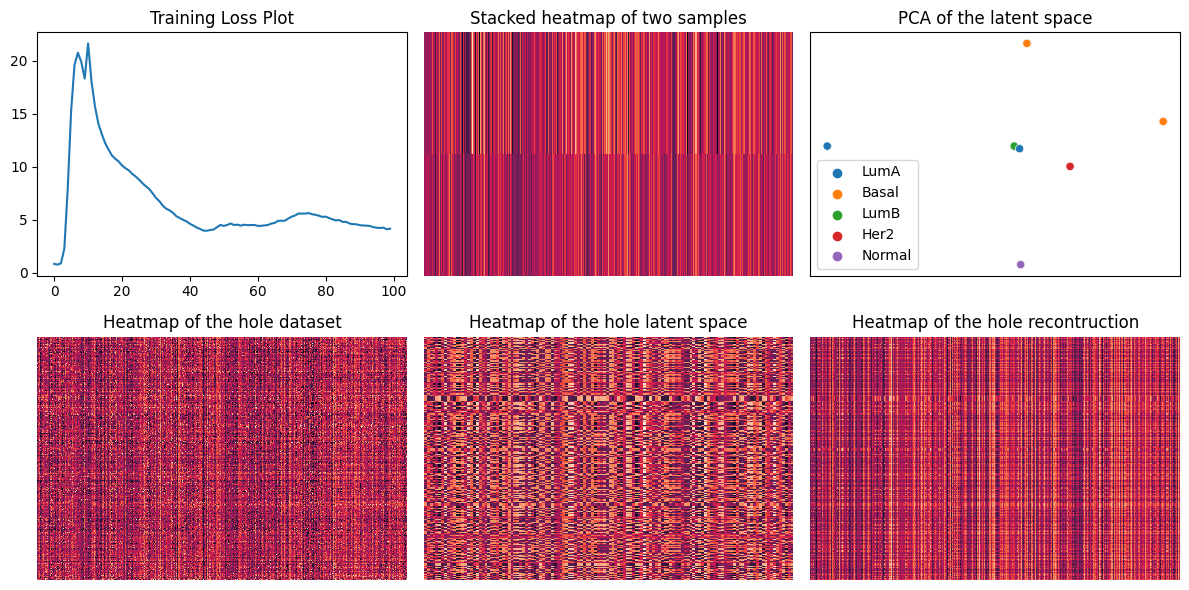

{'hopkins': 0.9996136597129223, 'ari': 0.1286939394205916, 'nmi': 0.2005301770727078, 'silhouette': 0.9361105, 'fm': 0.37459183483925274, 'homogeneity': 0.22213103357455324, 'completeness': 0.1827580932560211, 'v_measure': 0.2005301770727078}
new best performer : {'convolution': True, 'transformer': False, 'dropout': 0.3, 'latent_dim': 128, 'num_layers': 1, 'padding': 1, 'kernel_size': 3, 'variational': 'VQ-VAE', 'commitment_cost': 0.2, 'embedding_dim': 128, 'num_embeddings': 128}
Score achieved : 0.1286939394205916


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


input shape : 6963
(1521, 6963)
(1521, 1, 6963)
train data: 1521
Running the following configuration:
../workfiles/PPMI_genes.pkl
{'convolution': True, 'transformer': False, 'dropout': 0.3, 'latent_dim': 128, 'num_layers': 1, 'padding': 1, 'kernel_size': 3, 'variational': 'VQ-VAE', 'commitment_cost': 0.2, 'embedding_dim': 128, 'num_embeddings': 128}


  1%|          | 9/1000 [00:48<1:28:33,  5.36s/it]C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  1%|          | 10/1000 [00:55<1:34:43,  5.74s/it]C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  1%|          | 12/1000 [01:07<1:35:35,  5.81s/it]C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_

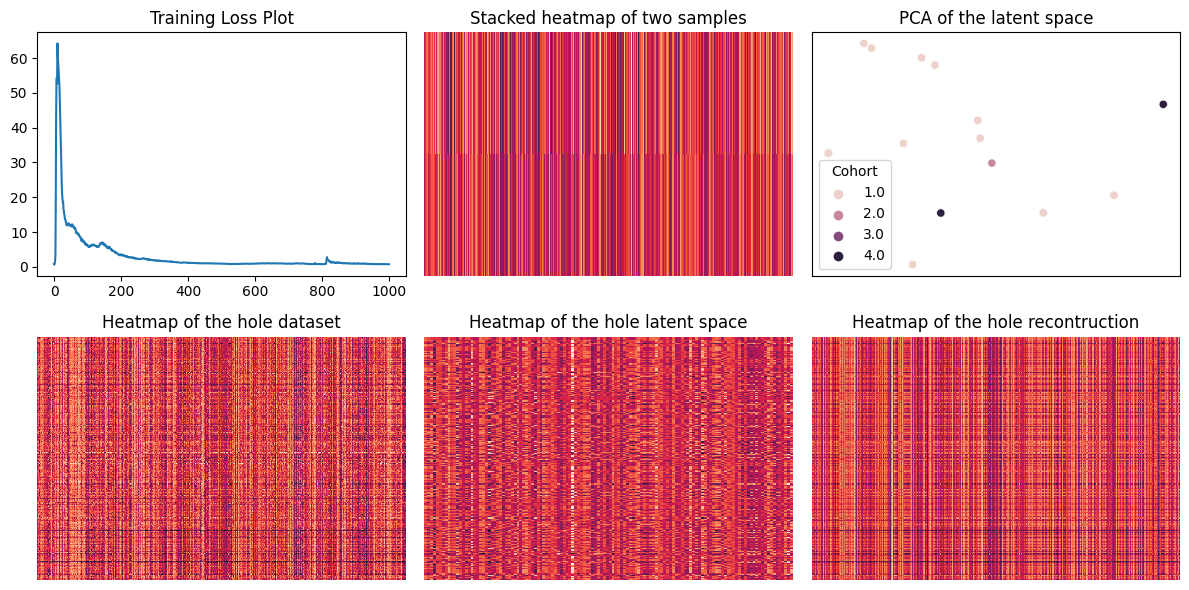

{'hopkins': 0.9994832044683509, 'ari': 0.0013358806209883582, 'nmi': 0.003939108087391387, 'silhouette': 0.65632737, 'fm': 0.38567590921163614, 'homogeneity': 0.006415069300660386, 'completeness': 0.0028421510109337854, 'v_measure': 0.003939108087391388}
input shape : 13067
(397, 13067)
(397, 1, 13067)
train data: 397
Running the following configuration:
../workfiles/PPMI_genes_PD_only.pkl
{'convolution': True, 'transformer': False, 'dropout': 0.3, 'latent_dim': 128, 'num_layers': 1, 'padding': 1, 'kernel_size': 3, 'variational': 'VQ-VAE', 'commitment_cost': 0.2, 'embedding_dim': 128, 'num_embeddings': 128}


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 0/1000 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.54 GiB (GPU 0; 6.00 GiB total capacity; 10.71 GiB already allocated; 0 bytes free; 10.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
s.run()

In [10]:
print(s.best_performer)
print(s.best_performer_metric)
print(s.n_iter)
print(s.current_generation)


{'convolution': True, 'transformer': False, 'dropout': 0.5, 'latent_dim': 32, 'num_layers': 5, 'padding': 3, 'kernel_size': 7, 'variational': 'VAE'}
0.07481011897852471
0
0


{'variational': False, 'convolution': True, 'transformer': False, 'dropout': 0.3, 'latent_dim': 16, 'padding': 2, 'kernel_size': 5}

0.26742224886270843

70

0